In [8]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology

In [9]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [10]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

.

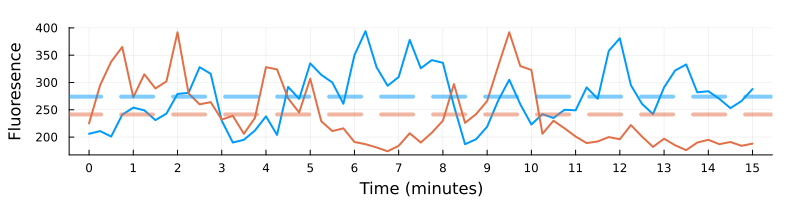

In [67]:
file = "../2024_09_26-3XGBpak1Del/2patch/movie12-cell4.tif"
file = "../2024_09_26-3XGBwt/2patch/movie1-cell7.tif"
interval = 15
time_threshold=0.5
masks = mask_site(file, 0.3, n_sites=2);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-1)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, 
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
plot!(t, crop2, xticks=range(0,15), linewidth=2, label=false)
hline!([mean(crop1)], linewidth=4, label=false, linestyle=:dash, color=1, alpha=0.5)
hline!([mean(crop2)], linewidth=4, label=false, linestyle=:dash, color=2, alpha=0.5)
#savefig("../figures/3XGB_2site_m1c7.png")

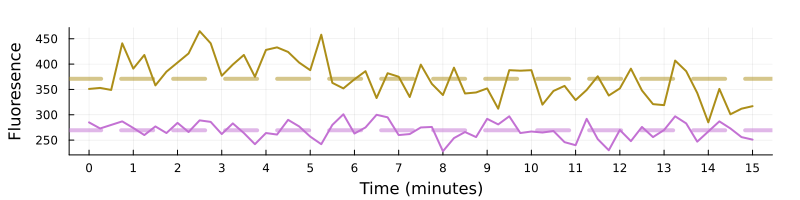

In [12]:
file = "../2024_09_26-3XGBpak1Del/2patch/movie12-cell3.tif"
#file = "../2024_09_26-3XGBwt/2patch/movie1-cell7.tif"
interval = 15
time_threshold=0.5
masks = mask_site(file, 0.3, n_sites=2);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-3)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, color=5,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
plot!(t, crop2, xticks=range(0,15), linewidth=2, label=false, color=4)
hline!([mean(crop1)], linewidth=4, label=false, linestyle=:dash, color=5, alpha=0.5)
hline!([mean(crop2)], linewidth=4, label=false, linestyle=:dash, color=4, alpha=0.5)
#savefig("../figures/3XGBdelp_2site_m12c3.png")

In [61]:
dir_wt = "../2024_09_26-3XGBwt/1patch/"
cov_threshold = 0.3
files_wt = readdir(dir_wt)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(31, (length(files_wt)))
peaks_ac = []
t_cor = range(0,30)*(15/60)
n = 0
for f in files_wt
    masks = mask_site("$dir_wt$f", cov_threshold, n_sites=1)
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    q1 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:30)
    all_cor[:,n+1] = cor1
    
    n+=1
    plot!(t_cor, cor1, x_ticks=1:8, linewidth=3, alpha=0.5, label=false, ylim=(-0.5,1))
    mac = findlocalmaxima(cor1, window=(5,), edges=false)
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        append!(peaks_ac, mac[1] * (15/60))
    end
end

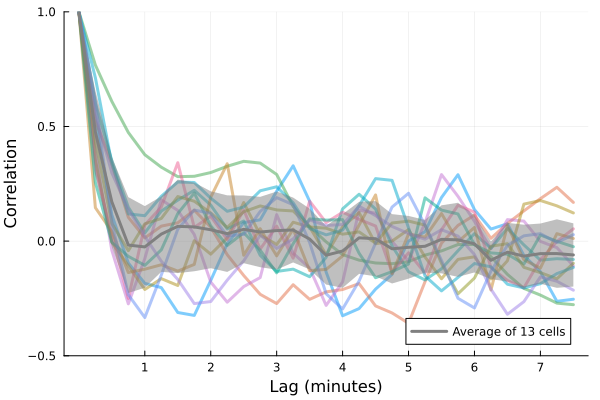

In [62]:
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(n) cells", ylim=(-0.5,1))


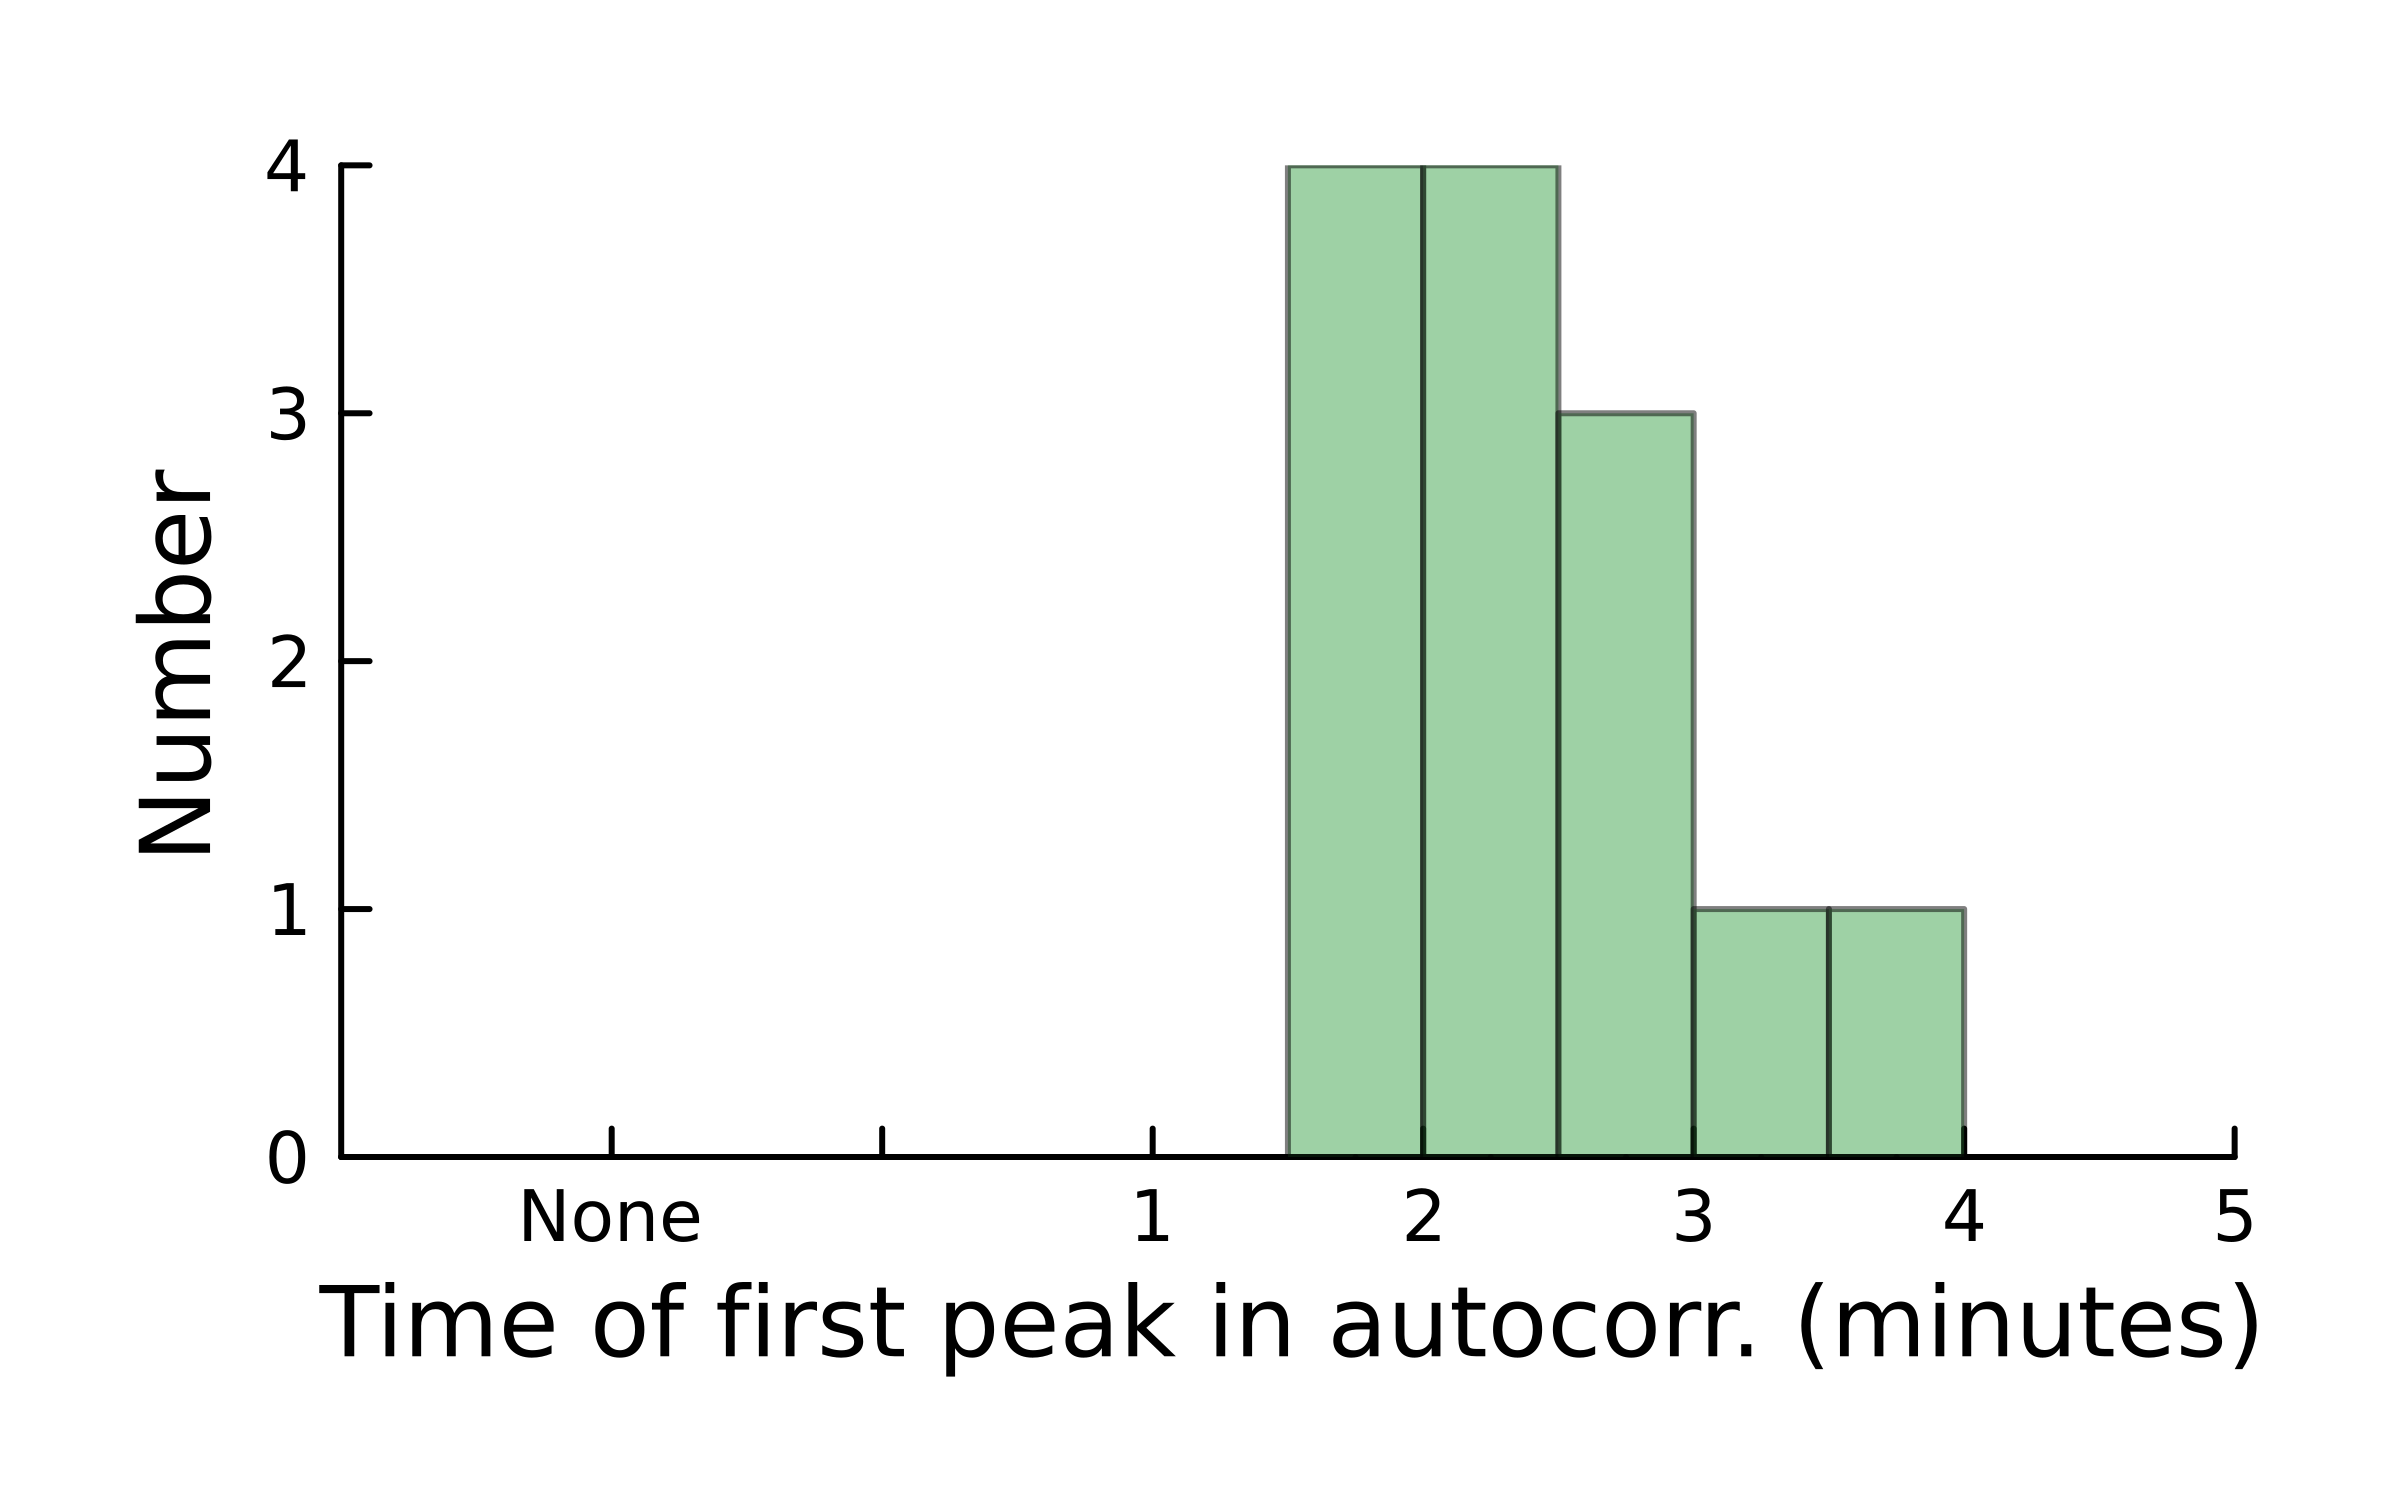

In [63]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac)
nonpeaks = zeros(length(nonpeaks))
histogram(peaks, alpha=0.5,bins=1:0.5:5, grid=false, legend=false, xticks=(-1:7, ("None", "",1,2,3,4,5)), dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)
histogram!(nonpeaks, bins=-1.25:0.5:5.25, alpha=0.5, color="red", xlims=(-2,5))

In [64]:
dir_del = "../2024_09_26-3XGBpak1Del/1patch/"
cov_threshold = 0.3
files_del = readdir(dir_del)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(31, (length(files_del)))
peaks_ac = []
t_cor = range(0,30)*(15/60)
n = 0
for f in files_del
    masks = mask_site("$dir_del$f", cov_threshold, n_sites=1)
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    q1 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:30)
    all_cor[:,n+1] = cor1
    n+=1
    plot!(t_cor, cor1, x_ticks=1:8, linewidth=3, alpha=0.5, label=false, ylim=(-0.5,1))
    mac = findlocalmaxima(cor1, window=(7,), edges=false)
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        append!(peaks_ac, mac[1] * (15/60))
    end
end

..

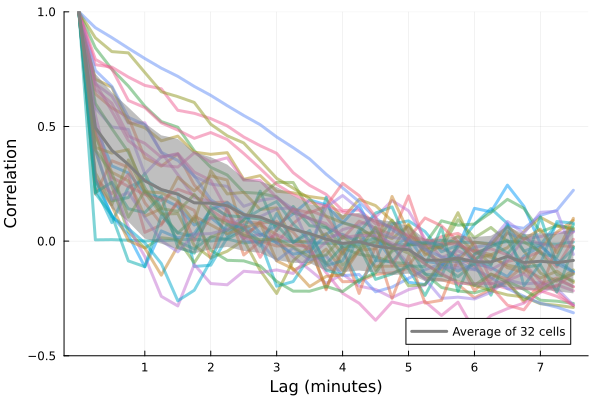

In [65]:
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(n) cells", ylim=(-0.5,1))


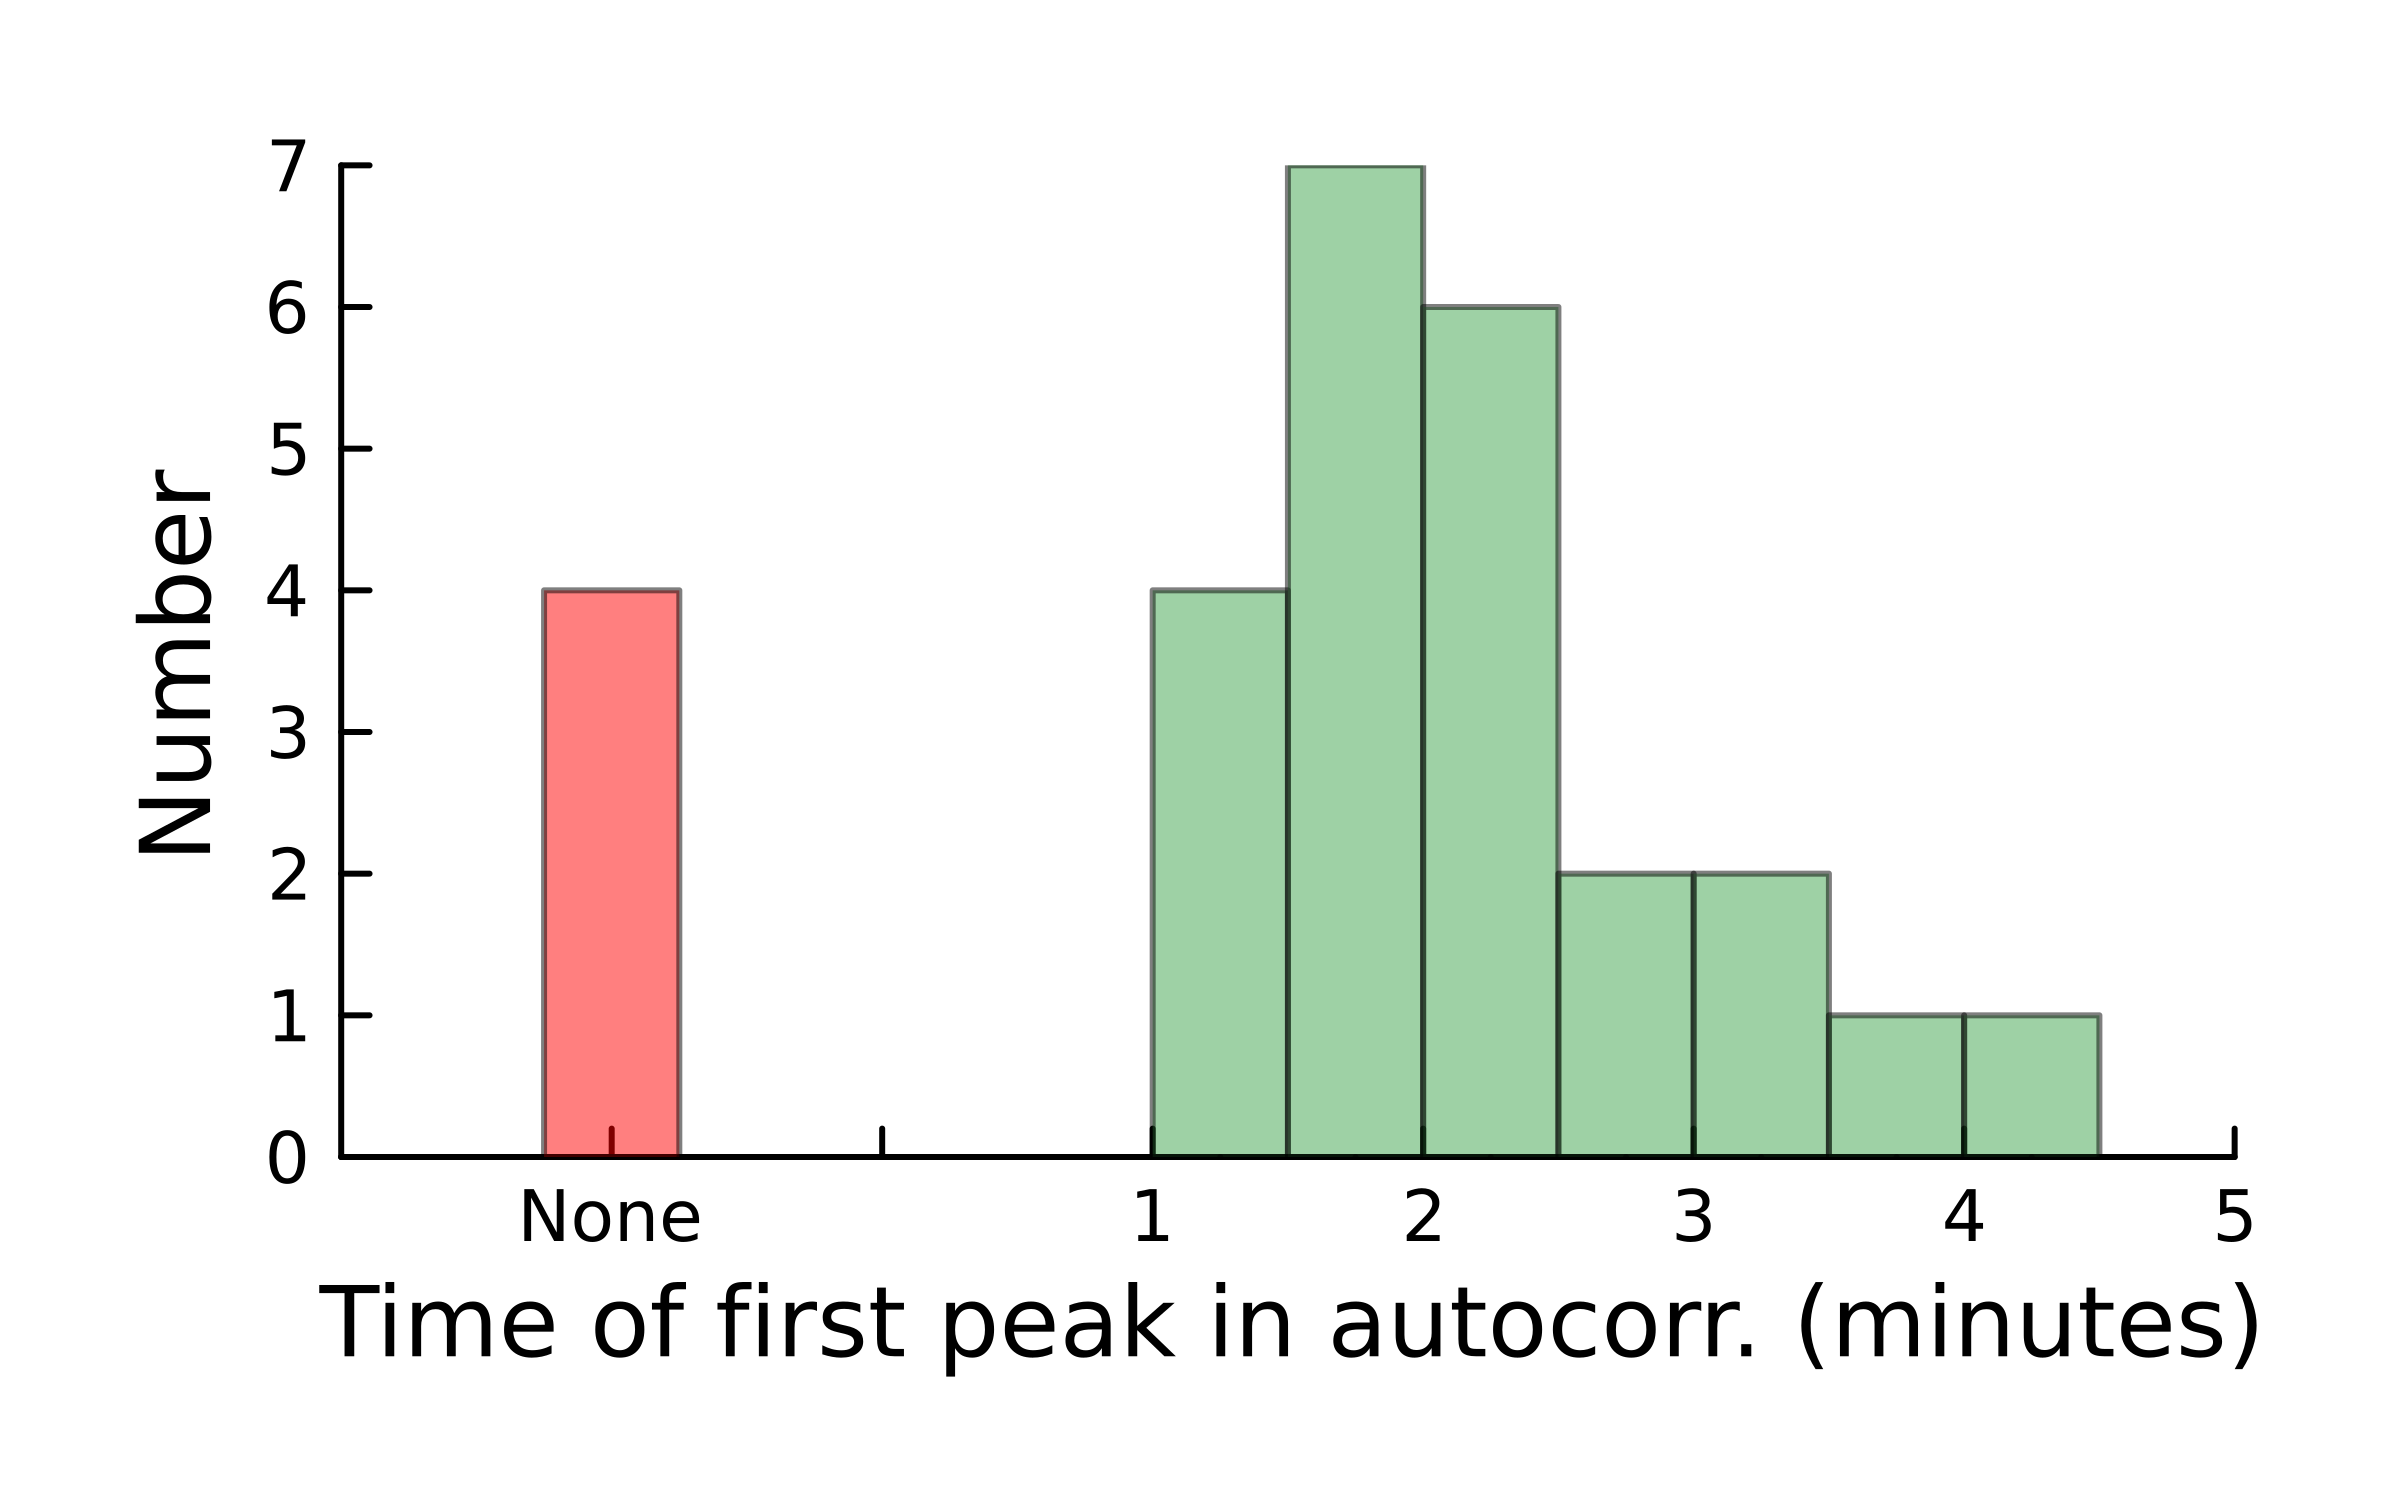

In [56]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac)
nonpeaks = zeros(length(nonpeaks)) .-1.25
histogram(peaks, alpha=0.5,bins=1:0.5:5, grid=false, legend=false, xticks=(-1:7, ("None", "",1,2,3,4,5)), dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)
histogram!(nonpeaks, bins=-1.25:0.5:5, alpha=0.5, color="red", xlims=(-2,5))
#savefig("../figures/Pak1GFP_xcor_period_histogram.png")

In [62]:
dir_wt = "../2024_09_26-3XGBwt/2patch/"
cov_threshold = 0.3
files_wt = readdir(dir_wt)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(31, (length(files_wt)*2))
peaks_ac = zeros(length(files_wt)*2)
wt_diffs = zeros(length(files_wt))
t_cor = range(0,30)*(15/60)
n = 0
for f in files_wt
    masks = mask_site("$dir_wt$f", cov_threshold, n_sites=2)
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    m2 = masks[:,:,:,2]
    q1 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
    q2 = vquantile(m2, (im_size-3)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    crop2 = q2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:30)
    cor2 = crosscor(crop2, crop2, 0:30)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=1
    plot!(t_cor, cor1, x_ticks=1:8, linewidth=3, alpha=0.5, label=false, ylim=(-0.5,1))
    mac = findlocalmaxima(cor1)[2]
    peaks_ac[n] = mac[1] * (15/60)
    n+=1
    mac = findlocalmaxima(cor2)[2]
    peaks_ac[n] = mac[1] * (15/60)
    wt_diffs[Int(n/2)] = abs(mean(crop1) - mean(crop2))
end

......

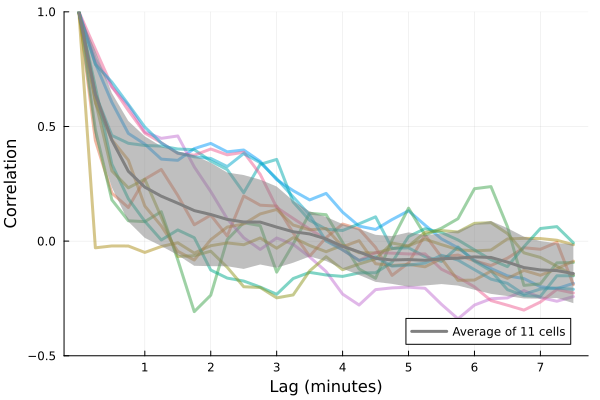

In [85]:

stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))


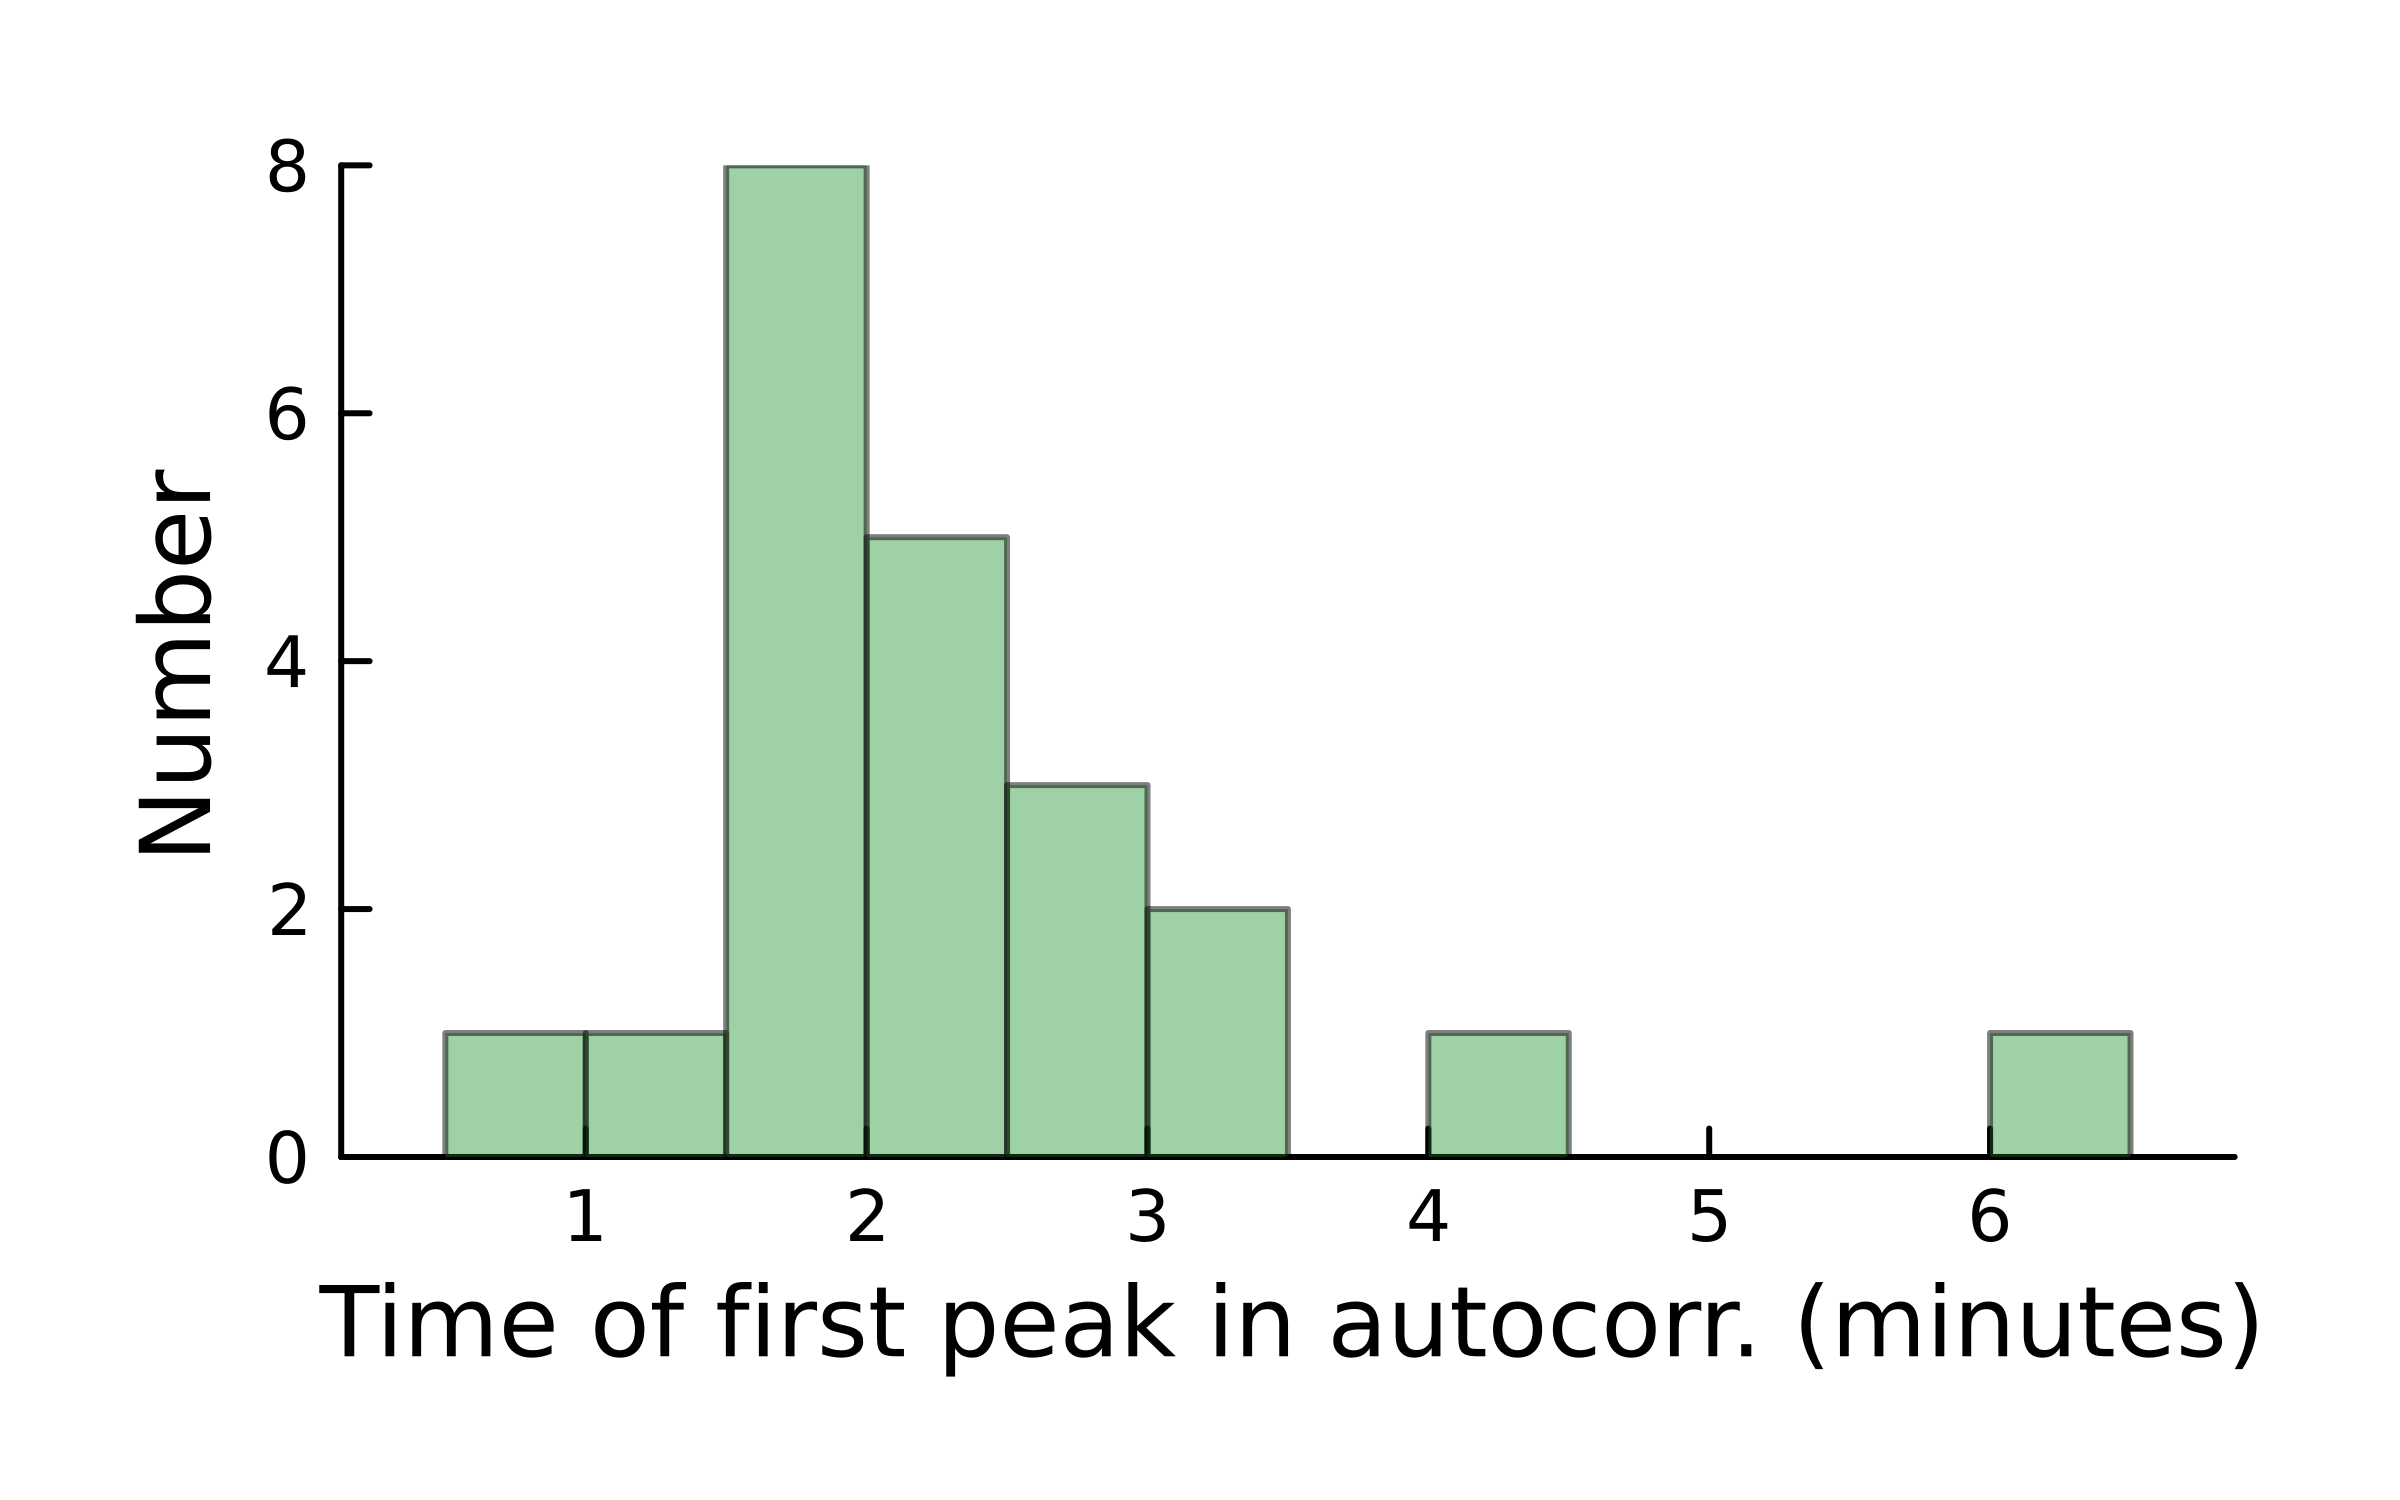

In [86]:
histogram(peaks_ac, alpha=0.5,bins=15, grid=false, legend=false, xticks=1:10, dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)

In [61]:
dir_del = "../2024_09_26-3XGBpak1Del/2patch/"
cov_threshold = 0.3
files_del = readdir(dir_del)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(31, (length(files_del)*2))
peaks_ac = zeros(length(files_del)*2)
del_diffs = zeros(length(files_del))
t_cor = range(0,30)*(15/60)
n = 0
for f in files_del
    masks = mask_site("$dir_del$f", cov_threshold, n_sites=2)
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    m2 = masks[:,:,:,2]
    q1 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
    q2 = vquantile(m2, (im_size-3)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    crop2 = q2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:30)
    cor2 = crosscor(crop2, crop2, 0:30)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=1
    plot!(t_cor, cor1, x_ticks=1:8, linewidth=3, alpha=0.5, label=false, ylim=(-0.5,1))
    if length(findlocalmaxima(cor1)) > 1
        mac = findlocalmaxima(cor1)[2]
        peaks_ac[n] = mac[1] * (15/60)
    end
    n+=1
    if length(findlocalmaxima(cor2)) > 1
        mac = findlocalmaxima(cor2)[2]
        peaks_ac[n] = mac[1] * (15/60)
    end
    del_diffs[Int(n/2)] = abs(mean(crop1) - mean(crop2))
end

.......

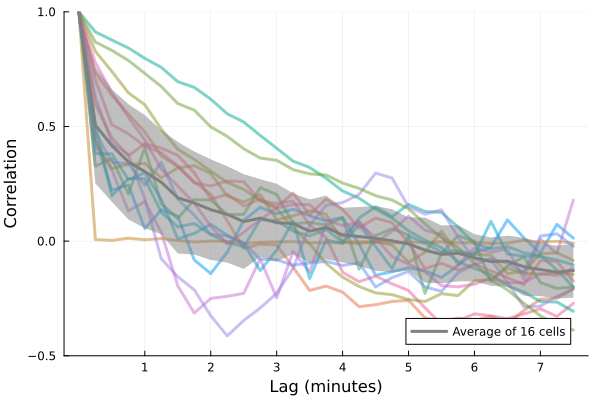

In [88]:

stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))


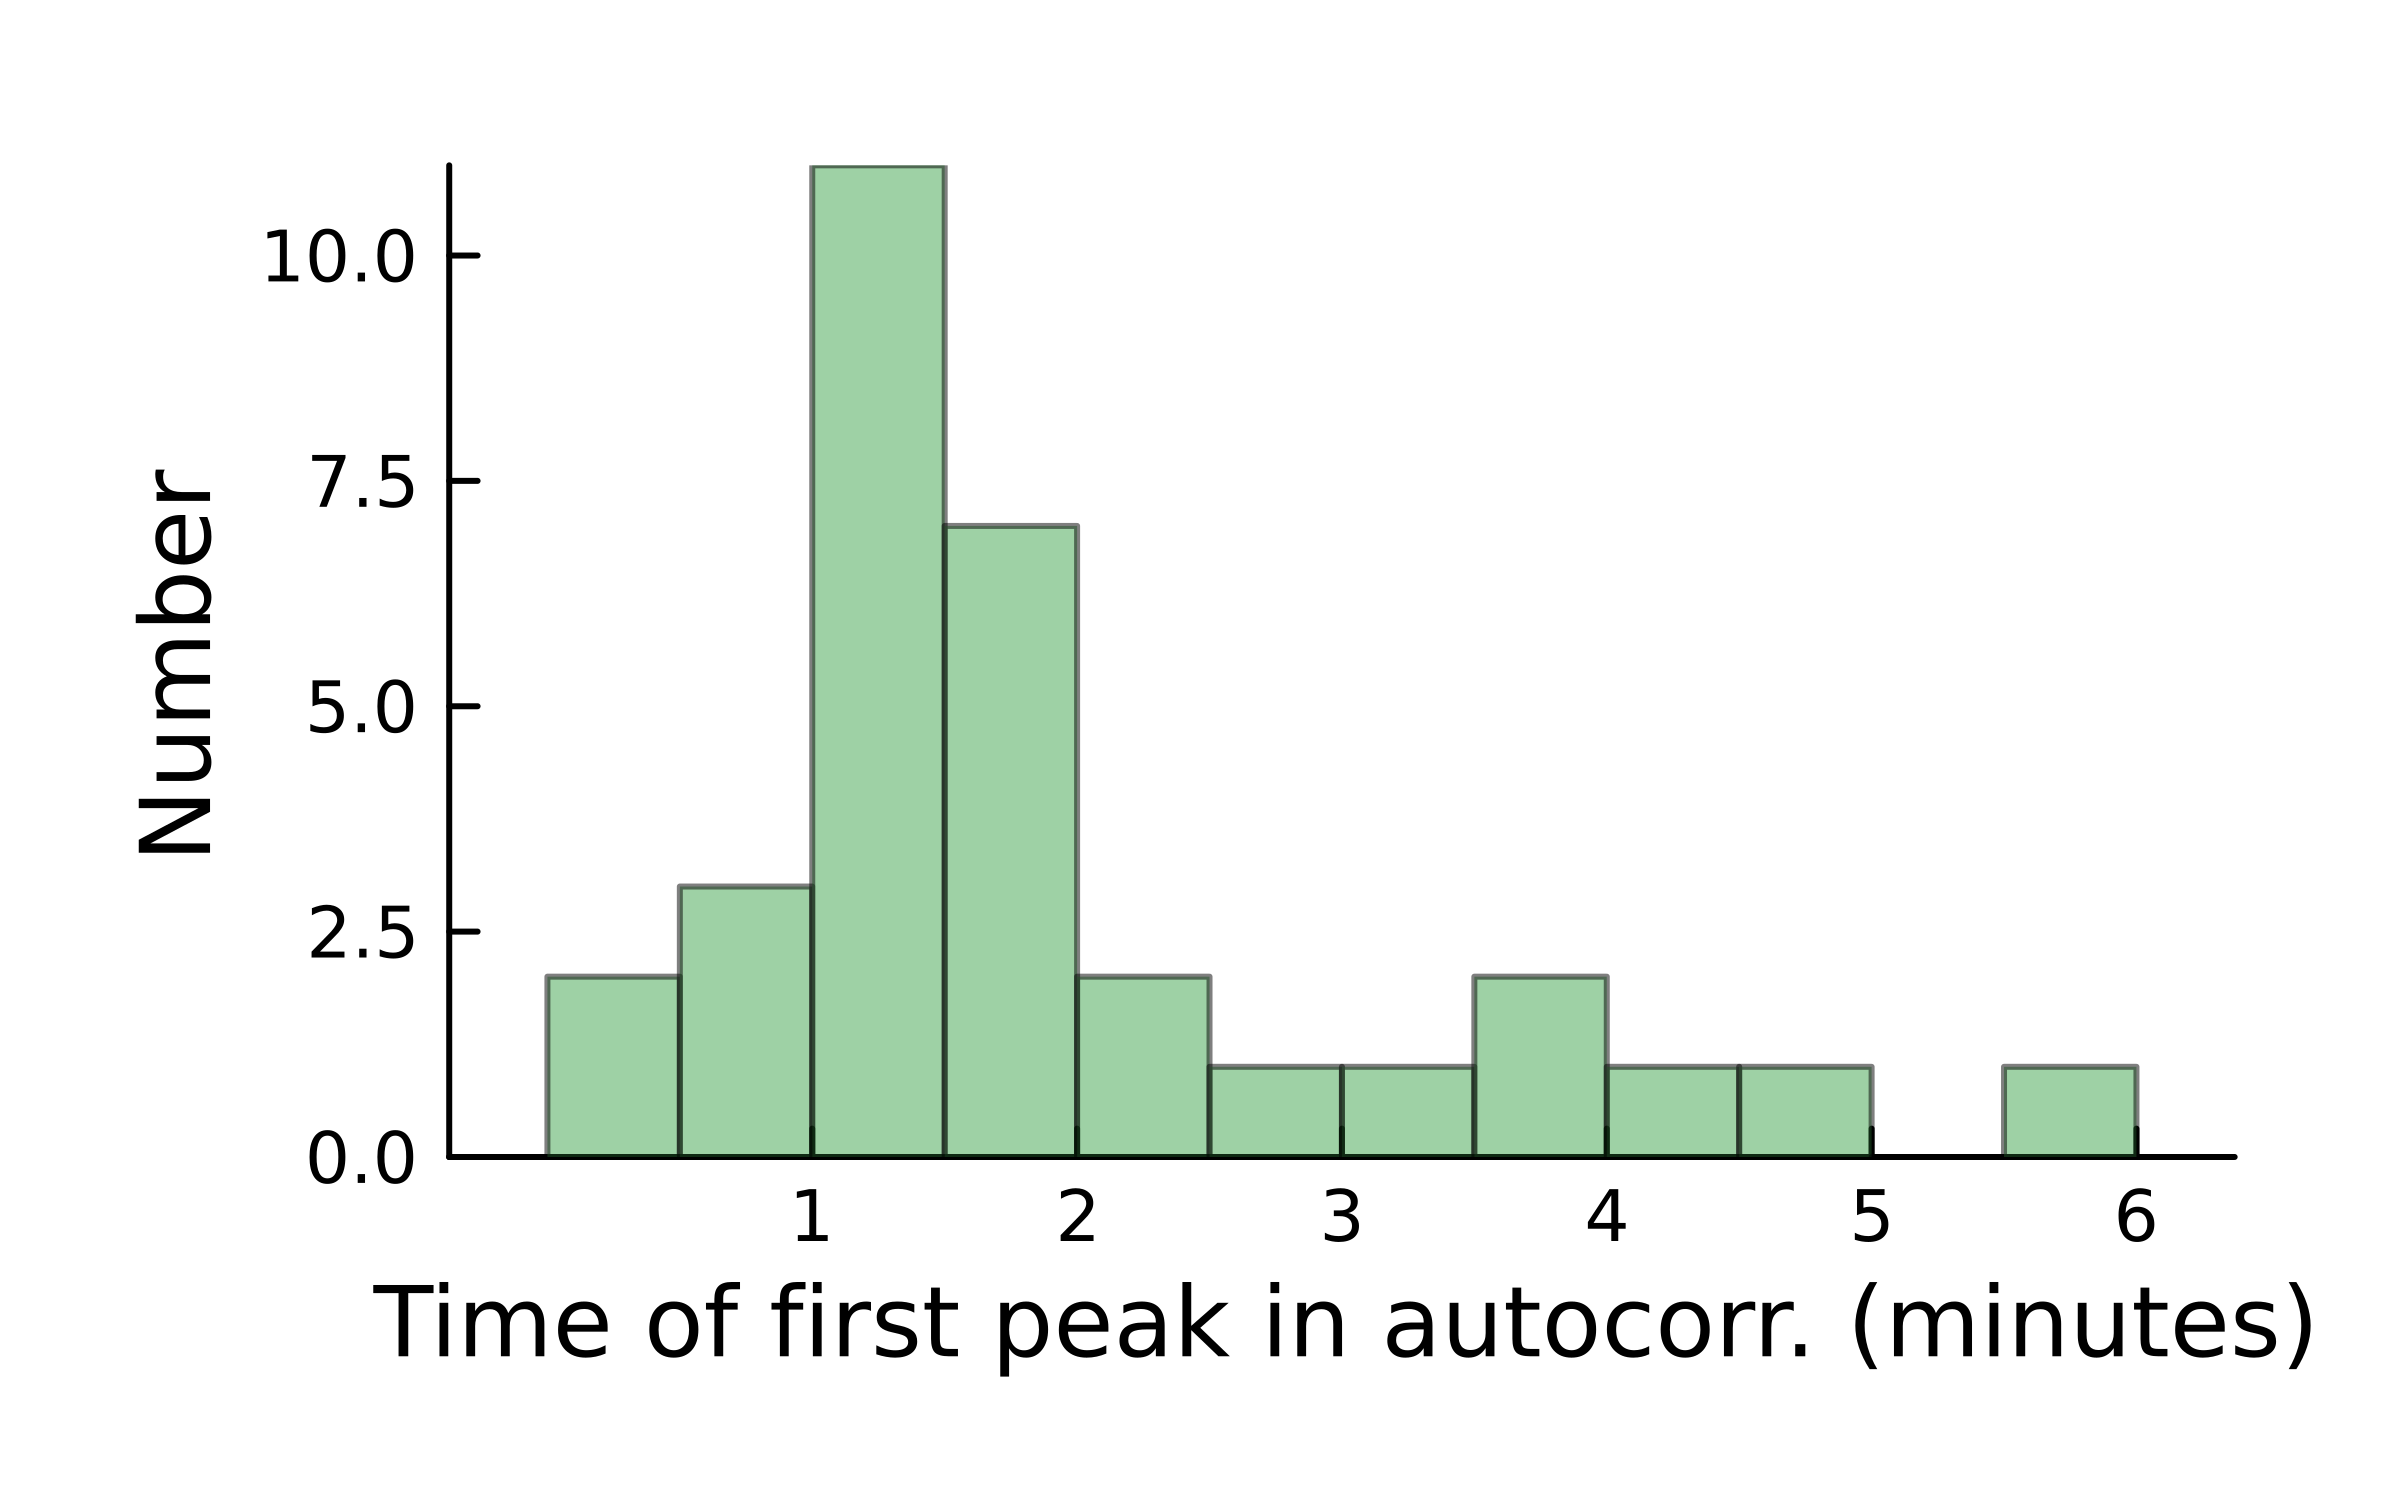

In [89]:
histogram(peaks_ac, alpha=0.5,bins=15, grid=false, legend=false, xticks=1:10, dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)

In [163]:
using StatsPlots
using Random
scatter(rand(length(wt_diffs)),wt_diffs, x_ticks = ([.5, 10.5], ["wt","pak1"]),
    label=false, margin=5Plots.mm, dpi=600, size=(250,400), xlims=(-5,15), ylims=(-10,420), alpha=0.5, markersize=7, color=1)
scatter!(10 .+ rand(length(del_diffs)),del_diffs, label=false, alpha=0.5, markersize=7, yaxis="Difference of means", color=5, grid=false)
savefig("../figures/mean_I_diffs.png")

"/home/dinosaur/Lab/Polarity/proj/fig6-deletions/figures/mean_I_diffs.png"